In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import multiseg as ms
import pandas as pd
import numpy as np
%matplotlib inline 
from IPython.display import display, Markdown
import glob

In [2]:
network_type = 'drive'                    #get walkable streets and paths (ignores directionality)
retain_all = False                       #retain all only largest connected component
crs_osm = {'init':'epsg:4326'}           #crs that osm uses
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops'                    #the input file for all bus stop shaspes
allFiles = glob.glob('{}/{}/*.shp'.format(input_folder, busStop)) #list of all bus stop shapes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))

busStop_list = []

for file_ in allFiles:
    lineNum = file_.split('linea_',1)[1].split('.')[0]
    df = gpd.read_file(file_)
    df['lineNum'] = int(lineNum)
    busStop_list.append(df)
busStopGPD = gpd.GeoDataFrame(pd.concat(busStop_list, ignore_index = True))

#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(input_folder, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

NameError: name 'plt' is not defined

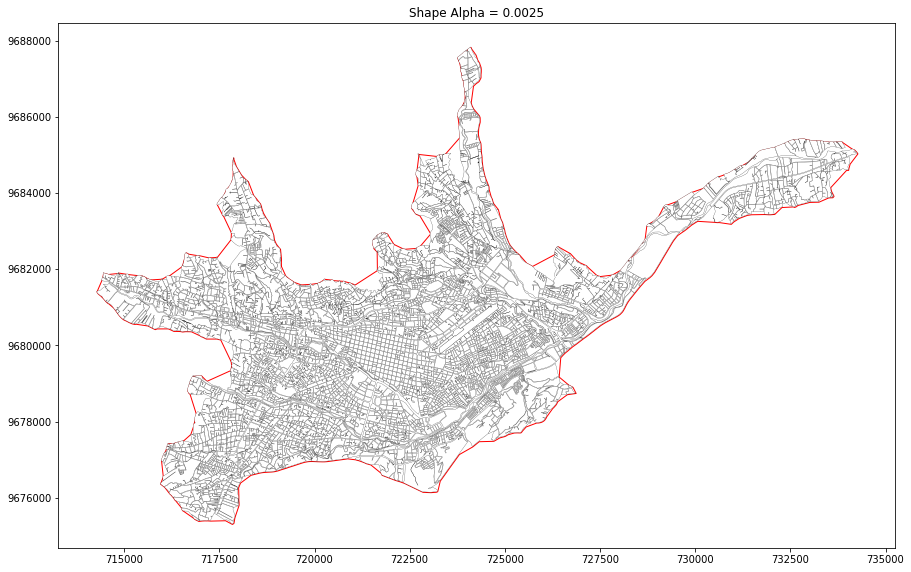

In [9]:
alpha = 0.0025
temp = ms.boundary_from_areas(blocksGPD, alpha = alpha)
base = temp.plot(color = 'white',edgecolor='red',linewidth=1, figsize = (15,10))
base.set_title("Shape Alpha = {}".format(alpha))
blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  ax = base)
plt.show()

In [7]:
geom=blocksGPD.geometry

In [10]:
points=ms.get_vertex_of_polygons(geom)

In [ ]:
%%timeit
test = ms.boundary_from_areas(blocksGPD, alpha=0.0025, buffer_dist=200)

In [ ]:
test


In [ ]:
all(isinstance(x, ms.geometry.point.Point) for x in points)

In [17]:
help(ms.get_vertex_of_polygons)

Help on function get_vertex_of_polygons in module multiseg.processGeom:

get_vertex_of_polygons(geom)
    Get list of vertices of all polygons in polygon list.
    
    Parameter
    ---------
    :param geom: geopandas.GeoSeries
        geometries of city blocks.
    
    Returns
    -------
    :return: list
        list of vertices of polygons



In [86]:
from shapely import geometry
block_1 = geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
block_2 = geometry.Polygon([(2, 0), (2, 1), (3, 1), (3, 0)])
block_3 = geometry.Polygon([(0, 2), (0, 3), (1, 3), (1, 2)])
block_4 = geometry.Polygon([(2, 2), (2, 3), (3, 3), (3, 2)])
multi_block = geometry.MultiPolygon([block_3, block_4])
l = geometry.LineString([(1.5,0),(1.5,3)])


simple_box = gpd.GeoSeries(block_1)
multi_box = gpd.GeoSeries([block_1, block_2, block_3, block_4])
multi_box_2 = gpd.GeoSeries(multi_block)
mixed_box = gpd.GeoSeries([block_1, block_2, multi_block])
mixed_geom = gpd.GeoSeries([block_1, block_2, multi_block, l])
line = gpd.GeoSeries(l)

In [117]:
points = ms.get_vertex_of_polygons(simple_box)
# points.append(1)

In [123]:
coords = np.array([point.coords[0] for point in points])

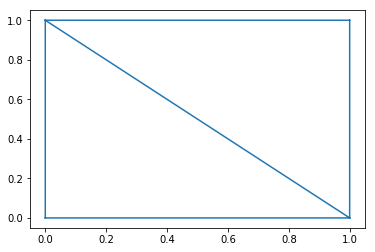

In [135]:
tri = ms.Delaunay(coords)
import matplotlib.pyplot as plt
plt.triplot(coords[:,0], coords[:,1], tri.simplices.copy())

In [49]:
all(isinstance(x, geometry.point.Point) for x in ms.get_vertex_of_polygons(multi_box))

True

In [142]:
alpha = 1

edges = set()
edge_points = []

import math
from shapely.ops import cascaded_union, polygonize
def add_edge(i, j):
    if (i, j) in edges or (j, i) in edges:
        return
    edges.add((i, j))
    edge_points.append(coords[[i, j]])

for ia, ib, ic in tri.simplices:
    pa = coords[ia]
    pb = coords[ib]
    pc = coords[ic]

    # calculate length of side of triangles
    a = math.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
    b = math.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
    c = math.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)

    # calculate semiperimeter of triangle
    s = (a + b + c) / 2.0

    # calculate area of triangle
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    if area == 0:
        circum_r = 0
    elif area > 0:
        circum_r = a * b * c / (4.0 * area)
    else:
        pass

    # radius filter
    if circum_r < 1.0 / alpha:
        add_edge(ia, ib)
        add_edge(ib, ic)
        add_edge(ic, ia)

m = geometry.MultiLineString(edge_points)
triangles = list(polygonize(m))
res = cascaded_union(triangles)

In [157]:
import random
points = []
for number in range(1,10):
    pnt = geometry.Point(random.uniform(0,10), random.uniform(0,10))
    points.append(pnt)

In [159]:
test = gpd.GeoSeries(points)

In [215]:
len(ms.boundary_from_areas(multi_box, 1.4)[0].exterior.coords)

13

In [216]:
len(ms.boundary_from_areas(mixed_box)[0].exterior.coords)

13

In [243]:
test = blocksGPD[:1]

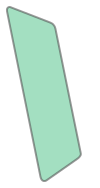

In [244]:
ms.boundary_from_areas(test,0.0001)[0]

In [246]:
test

,DPA_MANZAN,DPA_ANIO,DPA_SECTOR,geometry
0,01015002300504,0101,010150023005,"POLYGON ((726494.9511000002 9680565.418299999,..."


In [254]:
block_1 = geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
block_2 = geometry.Polygon([(2, 0), (2, 1), (3, 1), (3, 0)])
block_3 = geometry.Polygon([(0, 2), (0, 3), (1, 3), (1, 2)])
block_4 = geometry.Polygon([(2, 2), (2, 3), (3, 3), (3, 2)])
multi_block = geometry.MultiPolygon([block_3, block_4])

simple_blocks = gpd.GeoDataFrame({"id": [1,2,3],
                                  "geometry": [block_1, block_2, multi_block]
                                 })

In [306]:
##create regular square grid block
blocks = []
ids = []
x_min = 0
n = 5

for i in range(n):
    x_max = x_min + 100 
    y_min = 0
    for j in range(0,n):
        y_max = y_min + 100
        blck = geometry.Polygon([(x_min, y_min),
                                 (x_max, y_min),
                                 (x_max, y_max),
                                 (x_min, y_max)
                                ])
        blocks.append(blck)
        ids.append(i * n + j)
        y_min = y_max + 20
    x_min = x_max + 20

blocks = gpd.GeoDataFrame({"id": ids, "geometry": blocks})

In [329]:
type(ms.boundary_from_areas(blocks, 0.01))

geopandas.geoseries.GeoSeries

100.0